In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
# Dataset is from the  National Health and Nutrition Examination Survey (NHANES) conducted by the CDC

# This file contains the collected body measurements of the participants
with open("../data/BMX_L.XPT", "rb") as f:
    df_body = pd.read_sas(f, format="xport")

# This file contains the demographic information of the participants (including age)
with open("../data/DEMO_L.XPT", "rb") as f:
    df_demo = pd.read_sas(f, format="xport")

# Merge the two dataframes by the unique identifier SEQN
df = pd.merge(df_body, df_demo, on="SEQN")

df

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVSTRA,SDMVPSU,INDFMPIR
0,130378.0,1.0,86.9,NaN,NaN,NaN,NaN,NaN,179.5,NaN,...,NaN,NaN,NaN,NaN,NaN,50055.450807,54374.463898,173.0,2.0,5.00
1,130379.0,1.0,101.8,NaN,NaN,NaN,NaN,NaN,174.2,NaN,...,NaN,NaN,NaN,NaN,NaN,29087.450605,34084.721548,173.0,2.0,5.00
2,130380.0,1.0,69.4,NaN,NaN,NaN,NaN,NaN,152.9,NaN,...,NaN,NaN,NaN,NaN,NaN,80062.674301,81196.277992,174.0,1.0,1.41
3,130381.0,1.0,34.3,NaN,NaN,NaN,NaN,NaN,120.1,NaN,...,2.0,2.0,2.0,3.0,NaN,38807.268902,55698.607106,182.0,2.0,1.53
4,130382.0,3.0,13.6,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,2.0,2.0,3.0,1.0,2.0,30607.519774,36434.146346,182.0,2.0,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8855,142306.0,1.0,25.3,NaN,NaN,NaN,NaN,NaN,128.0,NaN,...,1.0,3.0,3.0,3.0,NaN,11147.192563,13459.129019,176.0,1.0,2.01
8856,142307.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,143.8,NaN,...,NaN,NaN,NaN,NaN,NaN,69419.620456,64962.328962,181.0,1.0,NaN
8857,142308.0,1.0,79.3,NaN,NaN,NaN,NaN,NaN,173.3,NaN,...,NaN,NaN,NaN,NaN,NaN,32696.313477,44367.534132,183.0,2.0,1.95
8858,142309.0,1.0,81.9,NaN,NaN,NaN,NaN,NaN,179.1,NaN,...,NaN,NaN,NaN,NaN,NaN,30547.974564,46249.361849,176.0,1.0,3.11


In [3]:
age = df["RIDAGEYR"].to_numpy() # age in years (capped at 80)
weight = df["BMXWT"].to_numpy() # weight in kg
height = df["BMXHT"].to_numpy() # height in cm
gender = df["RIAGENDR"].to_numpy() # gender

stacked = np.stack((age, weight, height, gender), axis=1)
print(stacked.shape)
stacked = stacked[~np.isnan(stacked).any(axis=1)]
print(stacked.shape)

height = 3  # for the jointplot
joint_marginal_ratio = 4
kde_linewidth = 1.1
cond_line_width = 1.5
num_hist_bins = 25

(8860, 4)
(8471, 4)


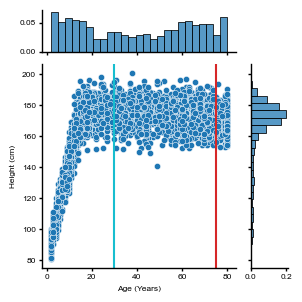

In [4]:
# Select age ranges here
stacked_males = stacked[stacked[:, 3] == 1]
heights_young = stacked_males[stacked_males[:, 0] == 30, 2]
heights_old = stacked_males[stacked_males[:, 0] == 75, 2]

with plt.rc_context(fname=".matplotlibrc"):
    g = sns.jointplot(
        x=stacked_males[:, 0],
        y=stacked_males[:, 2],
        kind="scatter",
        marginal_kws=dict(bins=num_hist_bins, stat="probability"),
        height=height,
        ratio=joint_marginal_ratio,
        marginal_ticks=True,
    )
    g.set_axis_labels("Age (Years)", "Height (cm)")

    g.ax_joint.axvline(x=30, color="C9", linewidth=cond_line_width)
    g.ax_joint.axvline(x=75, color="C3", linewidth=cond_line_width)
    g.ax_joint.set_ylim(auto=False)
    
    plt.tight_layout()
    plt.show()

(43,)
(43,)
Mean young: 176.83488372093024, Std young: 8.413607022318908
Mean old: 170.87906976744188, Std old: 7.956116796748561


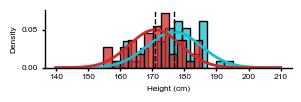

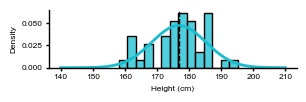

In [5]:
print(heights_young.shape)
print(heights_old.shape)

# Extract the MLE estimates for mu and sigma
mu_mle_young, sigma_mle_young = [np.mean(heights_young), np.std(heights_young)]
mu_mle_old, sigma_mle_old = [np.mean(heights_old), np.std(heights_old)]

print(f"Mean young: {mu_mle_young}, Std young: {sigma_mle_young}")
print(f"Mean old: {mu_mle_old}, Std old: {sigma_mle_old}")

# Plot histogram of data with fitted Gaussian curve
x = np.linspace(140, 210, 1000)
pdf_young = (1 / (sigma_mle_young * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_young) ** 2) / (2 * sigma_mle_young**2)
)
pdf_old = (1 / (sigma_mle_old * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_old) ** 2) / (2 * sigma_mle_old**2)
)

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    g = sns.histplot(
        heights_young,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="density",
        color="C9",
    )
    g = sns.histplot(
        heights_old,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="density",
        color="C3",
    )
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.plot(x, pdf_old, label="Fitted Gaussian (MLE)", color="C3", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # Add some vertical lines at the mean
    ax.axvline(mu_mle_young, color="black", linestyle="--", label="Mean (MLE)")
    ax.axvline(mu_mle_old, color="black", linestyle="--", label="Mean (MLE)")
    
    plt.tight_layout()
    plt.show()

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    g = sns.histplot(
        heights_young,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="density",
        color="C9",
    )
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # Add some vertical lines at the mean
    ax.axvline(mu_mle_young, color="black", linestyle="--", label="Mean (MLE)")
    
    plt.tight_layout()
    plt.show()

8.413607022318908 7.956116796748561


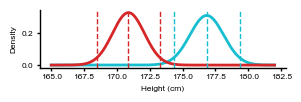

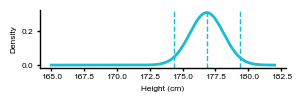

Mean and 95% CI for young
176.83488372093024
179.34968728372846
174.32008015813201
Mean and 95% CI for old
170.87906976744188
173.2571307837725
168.50100875111124


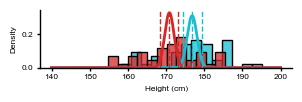

In [6]:
# Extract the MLE estimates for mu and sigma
mu_mle_young, sigma_mle_young = [np.mean(heights_young), np.std(heights_young)]
mu_mle_old, sigma_mle_old = [np.mean(heights_old), np.std(heights_old)]

print(sigma_mle_young, sigma_mle_old)

# Create standard error of the mean
sem_mle_young = sigma_mle_young / np.sqrt(heights_young.shape[0])
sem_mle_old = sigma_mle_old / np.sqrt(heights_old.shape[0])


# Plot histogram of data with fitted Gaussian curve
x = np.linspace(165, 182, 1000)
pdf_young = (1 / (sem_mle_young * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_young) ** 2) / (2 * sem_mle_young**2)
)
pdf_old = (1 / (sem_mle_old * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_old) ** 2) / (2 * sem_mle_old**2)
)

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.plot(x, pdf_old, label="Fitted Gaussian (MLE)", color="C3", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # add some vertical lines at the mean
    ax.axvline(
        mu_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_young + 1.96 * sem_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_young - 1.96 * sem_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_old,
        color="C3",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_old + 1.96 * sem_mle_old,
        color="C3",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_old - 1.96 * sem_mle_old,
        color="C3",
        linestyle="--",
        label="Mean (MLE)",
    )

    plt.tight_layout()
    plt.show()

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # add some vertical lines at the mean
    ax.axvline(
        mu_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_young + 1.96 * sem_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_young - 1.96 * sem_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )

    plt.tight_layout()
    plt.show()

x = np.linspace(140, 200, 10000)
pdf_young = (1 / (sem_mle_young * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_young) ** 2) / (2 * sem_mle_young**2)
)
pdf_old = (1 / (sem_mle_old * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_mle_old) ** 2) / (2 * sem_mle_old**2)
)


with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    g = sns.histplot(
        heights_young,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="probability",
        color="C9",
    )
    g = sns.histplot(
        heights_old,
        binwidth=65 / num_hist_bins,
        ax=ax,
        stat="probability",
        color="C3",
    )
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.plot(x, pdf_old, label="Fitted Gaussian (MLE)", color="C3", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # add some vertical lines at the mean
    ax.axvline(
        mu_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_young + 1.96 * sem_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_young - 1.96 * sem_mle_young,
        color="C9",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_old,
        color="C3",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_old + 1.96 * sem_mle_old,
        color="C3",
        linestyle="--",
        label="Mean (MLE)",
    )
    ax.axvline(
        mu_mle_old - 1.96 * sem_mle_old,
        color="C3",
        linestyle="--",
        label="Mean (MLE)",
    )

    # Print the means and CIs
    print("Mean and 95% CI for young")
    print(mu_mle_young)
    print(mu_mle_young + 1.96 * sem_mle_young)
    print(mu_mle_young - 1.96 * sem_mle_young)
    
    print("Mean and 95% CI for old")
    print(mu_mle_old)
    print(mu_mle_old + 1.96 * sem_mle_old)
    print(mu_mle_old - 1.96 * sem_mle_old)

    plt.tight_layout()
    plt.show()

Percentiles for young
174.546511627907
179.2983139534884
Percentiles for old
168.57174418604652
173.48883720930232


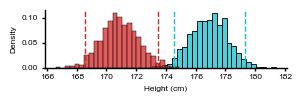

In [7]:
# Bootstrap the data
num_samples = 1000
bootstrap_samples_young = np.zeros((num_samples, heights_young.shape[0]))
bootstrap_samples_old = np.zeros((num_samples, heights_old.shape[0]))
for i in range(num_samples):
    bootstrap_samples_young[i] = np.random.choice(heights_young, heights_young.shape[0], replace=True)
    bootstrap_samples_old[i] = np.random.choice(heights_old, heights_old.shape[0], replace=True)

bootstrap_samples_young = np.mean(bootstrap_samples_young, axis=1)
bootstrap_samples_old = np.mean(bootstrap_samples_old, axis=1)

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    g = sns.histplot(
        bootstrap_samples_young,
        ax=ax,
        stat="probability",
        color="C9",
    )
    g = sns.histplot(
        bootstrap_samples_old,
        ax=ax,
        stat="probability",
        color="C3",
    )
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # add some vertical lines at the the 2.5 and 97.5 percentiles
    ax.axvline(
        np.percentile(bootstrap_samples_young, 2.5),
        color="C9",
        linestyle="--",
        label="2.5th percentile",
    )
    ax.axvline(
        np.percentile(bootstrap_samples_young, 97.5),
        color="C9",
        linestyle="--",
        label="97.5th percentile",
    )
    ax.axvline(
        np.percentile(bootstrap_samples_old, 2.5),
        color="C3",
        linestyle="--",
        label="2.5th percentile",
    )
    ax.axvline(
        np.percentile(bootstrap_samples_old, 97.5),
        color="C3",
        linestyle="--",
        label="97.5th percentile",
    )

    # Print the percentiles
    print("Percentiles for young")
    print(np.percentile(bootstrap_samples_young, 2.5))
    print(np.percentile(bootstrap_samples_young, 97.5))

    print("Percentiles for old")
    print(np.percentile(bootstrap_samples_old, 2.5))
    print(np.percentile(bootstrap_samples_old, 97.5))

    plt.tight_layout()
    plt.show()


Mean and 95% CI for young
179.29952185920573
174.31081045905248
Mean and 95% CI for old
173.29960177722396
168.57810508013975


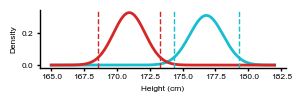

In [8]:
mu_prior = 175  # Prior mean
sigma_prior = 10  # Prior standard deviation

# Define likelihood parameters
mu_likelihood_young = np.mean(heights_young)  # Sample mean
sigma_likelihood_young = np.std(heights_young)  # Oracle standard deviation
n_young = len(heights_young)  # Sample size

mu_likelihood_old = np.mean(heights_old)  # Sample mean
sigma_likelihood_old = np.std(heights_old)  # Oracle standard deviation
n_old = len(heights_old)  # Sample size

# Compute posterior parameters
mu_posterior_young = (
    mu_prior / sigma_prior**2 + n_young * mu_likelihood_young / sigma_likelihood_young**2
) / (1 / sigma_prior**2 + n_young / sigma_likelihood_young**2)
sigma_posterior = np.sqrt(1 / (1 / sigma_prior**2 + n_young / sigma_likelihood_young**2))

mu_posterior_old = (
    mu_prior / sigma_prior**2 + n_old * mu_likelihood_old / sigma_likelihood_old**2
) / (1 / sigma_prior**2 + n_old / sigma_likelihood_old**2)
sigma_posterior2 = np.sqrt(1 / (1 / sigma_prior**2 + n_old / sigma_likelihood_old**2))

x = np.linspace(165, 182, 1000)
pdf_young = (1 / (sigma_posterior * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_posterior_young) ** 2) / (2 * sigma_posterior**2)
)
pdf_old = (1 / (sigma_posterior2 * np.sqrt(2 * np.pi))) * np.exp(
    -((x - mu_posterior_old) ** 2) / (2 * sigma_posterior2**2)
)

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, pdf_young, label="Fitted Gaussian (MLE)", color="C9", linewidth=2)
    ax.plot(x, pdf_old, label="Fitted Gaussian (MLE)", color="C3", linewidth=2)
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    # add some vertical lines at the mean
    ax.axvline(
        mu_posterior_young + 1.96 * sigma_posterior,
        color="C9",
        linestyle="--",
    )
    ax.axvline(
        mu_posterior_young - 1.96 * sigma_posterior,
        color="C9",
        linestyle="--",
    )
    ax.axvline(
        mu_posterior_old + 1.96 * sigma_posterior2,
        color="C3",
        linestyle="--",
    )
    ax.axvline(
        mu_posterior_old - 1.96 * sigma_posterior2,
        color="C3",
        linestyle="--",
    )

    # Print the means and CIs
    print("Mean and 95% CI for young")   
    print(mu_posterior_young + 1.96 * sigma_posterior)
    print(mu_posterior_young - 1.96 * sigma_posterior)

    print("Mean and 95% CI for old")
    print(mu_posterior_old + 1.96 * sigma_posterior2)
    print(mu_posterior_old - 1.96 * sigma_posterior2)

    plt.tight_layout()
    plt.show()

In [9]:
def perform_bayesian_inference(
    data, mu_prior=175, sigma_prior=10, alpha=6, beta=50, num_samples=1000
):
    with pm.Model() as model:
        mean_prior = pm.Normal("mean", mu=mu_prior, sigma=sigma_prior)
        std_prior = pm.InverseGamma("std", alpha=alpha, beta=beta)
        likelihood = pm.Normal(
            "likelihood", mu=mean_prior, sigma=std_prior, observed=data
        )

        trace = pm.sample(num_samples)

    # Summarize and plot the results
    print(pm.summary(trace))

    return (
        trace.posterior["mean"].values.flatten(),
        trace.posterior["std"].values.flatten(),
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Initializing NUTS using jitter+adapt_diag...


         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean  176.805  1.306  174.423  179.331      0.022    0.015    3672.0   
std     8.636  0.925    6.959   10.375      0.015    0.011    3801.0   

      ess_tail  r_hat  
mean    2714.0    1.0  
std     2612.0    1.0  


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, std]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean  170.911  1.268  168.460  173.232      0.021    0.015    3774.0   
std     8.212  0.884    6.582    9.811      0.014    0.010    4188.0   

      ess_tail  r_hat  
mean    2716.0    1.0  
std     2676.0    1.0  
Percentiles for young
174.2019115571867
179.33031879539232
Percentiles for old
168.36905454333393
173.35708661856535


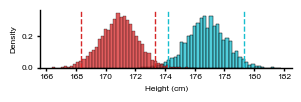

In [10]:
posterior_samples_young, _ = perform_bayesian_inference(heights_young)
posterior_samples_old, _ = perform_bayesian_inference(heights_old)

with plt.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(figsize=(3, 1))
    g = sns.histplot(
        posterior_samples_young,
        ax=ax,
        stat="density",
        color="C9",
    )
    g = sns.histplot(
        posterior_samples_old,
        ax=ax,
        stat="density",
        color="C3",
    )
    ax.set_xlabel("Height (cm)")
    ax.set_ylabel("Density")

    ax.axvline(
        np.percentile(posterior_samples_young, 2.5),
        color="C9",
        linestyle="--",
        label="2.5th percentile",
    )
    ax.axvline(
        np.percentile(posterior_samples_young, 97.5),
        color="C9",
        linestyle="--",
        label="97.5th percentile",
    )
    ax.axvline(
        np.percentile(posterior_samples_old, 2.5),
        color="C3",
        linestyle="--",
        label="2.5th percentile",
    )
    ax.axvline(
        np.percentile(posterior_samples_old, 97.5),
        color="C3",
        linestyle="--",
        label="97.5th percentile",
    )

    # Print the percentiles
    print("Percentiles for young")
    print(np.percentile(posterior_samples_young, 2.5))
    print(np.percentile(posterior_samples_young, 97.5))

    print("Percentiles for old")
    print(np.percentile(posterior_samples_old, 2.5))
    print(np.percentile(posterior_samples_old, 97.5))

    plt.tight_layout()
    plt.show()